## Benchmarks for our model implementations

In [1]:
import math
import numpy as np
import numba as nb
from numba import njit
import pandas as pd
from scipy.special import gammaln
from scipy.sparse import coo_matrix
from lenskit.matrix import CSR

from simulation_utils.preference import generate_ibp, generate_ibp_nb, \
    generate_ibp_nbp, generate_ibp_itemwise, generate_lda, generate_lda_nbp
from simulation_utils.preference import _draw_bernoulli, _draw_bernoulli_nbp
from simulation_utils.preference import _draw_nnew_ibp, _draw_nnew_ibp_nbp, _draw_poisson_nbp, \
    multinomial, _draw_multinomial_nbp
from simulation_utils.preference import IndianBuffetProcess, LatentDirichletAllocation
from simulation_utils.preference import LatentDirichletAllocationCOO
from simulation_utils.observation import PopularityObservation, sample_uniform_n, sample_popular_n, \
    UniformObservation
from simulation_utils.observation import PopularityObservationCOO, UniformObservationCOO, \
    sample_uniform_coo, sample_uniform_coo_nbp, sample_popular_coo, sample_popular_coo_nbp, TruncParetoProfile
from simulation_utils.datasets import ml_100k, ml_10m, bx_implicit, DataStats
from simulation_utils.calibration import compute_dstats, Calibrator, \
    _sample_pairs, _sample_pairs_nbp, compute_cosine_corr, pairwise_cosine_nbp
from simulation_utils.calibration import CalibratorCOO, pairwise_cosine_similarity
from simulation_utils.utils import compute_user_activity, TruncatedPareto, \
    truncated_pareto, truncated_pareto_nbp

### Data statistics distribution
- numpy vs pandas

In [4]:
data = ml_100k()

In [5]:
assert np.allclose(compute_dstats(data, normed=True).values, compute_user_activity(data))

In [6]:
%timeit compute_dstats(data).values
%timeit compute_user_activity(data)

3.69 ms ± 89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.31 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### compute_dstats is picked

In [7]:
%prun -l 10 compute_dstats(data.values)

         524 function calls (517 primitive calls) in 0.016 seconds

   Ordered by: internal time
   List reduced from 128 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.009    0.004    0.009    0.004 {method 'sort' of 'numpy.ndarray' objects}
        2    0.005    0.003    0.015    0.007 arraysetops.py:268(_unique1d)
        2    0.000    0.000    0.000    0.000 {method 'flatten' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method 'nonzero' of 'numpy.ndarray' objects}
       96    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        1    0.000    0.000    0.016    0.016 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 base.py:253(__new__)
        2    0.000    0.000    0.000    0.000 function_base.py:1079(diff)
        1    0.000    0.000    0.015    0.015 calibration.py:43(compute_dstats)
        2    0.000    0.000    0.001    0.0

In [8]:
%prun -l 10 compute_user_activity(data)

         9251 function calls (9132 primitive calls) in 0.024 seconds

   Ordered by: internal time
   List reduced from 508 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.004    0.002    0.004    0.002 {method 'factorize' of 'pandas._libs.hashtable.Int64HashTable' objects}
     1618    0.001    0.000    0.002    0.000 {built-in method builtins.isinstance}
        3    0.001    0.000    0.001    0.000 {pandas._libs.algos.take_2d_axis0_int64_int64}
        2    0.001    0.000    0.017    0.009 generic.py:1503(count)
    16/14    0.001    0.000    0.003    0.000 base.py:253(__new__)
      684    0.000    0.000    0.001    0.000 generic.py:7(_check)
        8    0.000    0.000    0.000    0.000 {pandas._libs.algos.take_1d_int64_int64}
  105/101    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
       11    0.000    0.000    0.001    0.000 managers.py:186(_rebuild_blknos_and_blklocs)
     

### Indian Buffet Process
#### lambda updates in indian buffet process
- numpy, numba, numba parallel

In [2]:
def ibp_update(nusers, alpha, c=1, sigma=0):
    log_gamma_a = gammaln(1 + c)
    log_gamma_b = gammaln(c + sigma)
    users = np.arange(1, nusers + 1)
    lam = alpha * np.exp(log_gamma_a + gammaln(users - 1 + c + sigma) - gammaln(users + c) - log_gamma_b)
    return lam

@njit
def ibp_update_nb(nusers, alpha, c=1, sigma=0):
    log_gamma_a = math.lgamma(1 + c)
    log_gamma_b = math.lgamma(c + sigma)
    users = np.arange(1, nusers + 1)
    lam = np.empty_like(users, dtype=np.float64)
    for i, u in np.ndenumerate(users):
        lam[i] = alpha * math.exp(log_gamma_a + math.lgamma(u - 1 + c + sigma) - math.lgamma(u + c) - log_gamma_b)
    return lam

@njit(parallel=True)
def ibp_update_nb_parallel(nusers, alpha, c=1, sigma=0):
    log_gamma_a = math.lgamma(1 + c)
    log_gamma_b = math.lgamma(c + sigma)
    lam = np.empty(nusers, dtype=np.float64)
    for u in nb.prange(1, nusers + 1):
        lam[u - 1] = alpha * math.exp(log_gamma_a + math.lgamma(u - 1 + c + sigma) - math.lgamma(u + c) - log_gamma_b)
    return lam

In [3]:
%timeit ibp_update(1000000, 2000)
%timeit ibp_update_nb(1000000, 2000)
%timeit ibp_update_nb_parallel(1000000, 2000)

81.7 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
125 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
lam1 = ibp_update(10000, 100)
lam2 = ibp_update_nb(10000, 100)
lam3 = ibp_update_nb_parallel(10000, 100)
assert np.allclose(lam1, lam2, rtol=1e-8)
assert np.allclose(lam2, lam3, rtol=1e-8)

### Draw new items and consumed items for each user.
- numpy vs numba parallel

In [5]:
%timeit _draw_nnew_ibp(80000, 20000)
%timeit _draw_nnew_ibp_nbp(80000, 20000)

9.39 ms ± 911 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.09 ms ± 62.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
prob = np.random.rand(80000)

%timeit _draw_bernoulli(prob)
%timeit _draw_bernoulli_nbp(prob)

4.76 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
775 µs ± 4.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Functions of Indian Buffect Process
- Iteration space on users: numpy, numba, numba with precomputed mean parameters, numba parallel on drawing history user consumed items and new items.
- Iteration space on items: numpy, multiprocessing parallel and numba parallel (drawing users for each item is independent)

In [3]:
@njit
def generate_ibppl(nusers, lambdas, c=1, sigma=0):
    """
    A generator of Indian Buffet Process with power law behavior

    Args:
        nusers (int): The number of users
        lambdas (1D-array): Precomputed mean parameters for drawing new users.

    Returns:
        list: picked items for each user.
    """
    # the number of items picked
    nitems_picked = 0
    # the number of users who tried for each item (m_k)
    npicks = np.ones(0, dtype=np.int64)
    # item list of picked items for each user
    items = []
    for u in range(1, nusers + 1):
        # pick from previously-used items with probability prob.
        # (len(prob) == nitems_picked)
        prob = (npicks - sigma) / (u - 1 + c)
        pick = np.empty_like(prob, dtype=np.bool_)
        for i, p in np.ndenumerate(prob):
            hit = np.random.binomial(np.int(1), p) > 0
            pick[i] = hit
        repicked_items = np.arange(nitems_picked)[pick]
        # update item pick counts
        npicks[pick] = npicks[pick] + 1
        # pick new items
        lam = lambdas[u-1]
        assert not np.isnan(lam)
        nnew = np.random.poisson(lam)
        new_items = np.arange(nitems_picked, nitems_picked + nnew)
        # add new items to picked ones
        if nnew > 0:
            npicks = np.hstack((npicks, np.ones(nnew, dtype=np.int64)))
            nitems_picked += nnew
            items.append(np.hstack((repicked_items, new_items)))
        else:
            items.append(repicked_items) 
    return items

In [ ]:
nusers = 10000
nitems = 100000
frac = 0.2
lambdas = ibp_update_nb(10000, nitems * frac)

In [13]:
%timeit generate_ibp(nusers, nitems * frac)

2min 34s ± 713 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%prun -l 20 generate_ibp(nusers, nitems * frac)

         8448571 function calls (8348567 primitive calls) in 159.488 seconds

   Ordered by: internal time
   List reduced from 227 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000   97.777    0.010   98.299    0.010 {method 'binomial' of 'mtrand.RandomState' objects}
        1   35.848   35.848  158.562  158.562 preference.py:55(generate_ibp)
    19207    9.157    0.000    9.157    0.000 {built-in method numpy.core.multiarray.concatenate}
    40001    6.261    0.000    6.261    0.000 {built-in method numpy.core.multiarray.arange}
    10000    1.891    0.000    2.319    0.000 internals.py:5017(_stack_arrays)
    59606    1.144    0.000    1.144    0.000 {built-in method numpy.core.multiarray.empty}
        1    0.926    0.926  159.488  159.488 <string>:1(<module>)
    10000    0.696    0.000    7.765    0.001 frame.py:426(_init_dict)
    40001    0.359    0.000    0.359    0.000 {method 'reduce' of 'numpy.ufunc' objects}
 

In [15]:
ibp = IndianBuffetProcess(nusers, nitems * frac)

In [16]:
%timeit ibp.generate()

1min 25s ± 758 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%prun -l 20 ibp.generate()

         7970079 function calls (7870075 primitive calls) in 88.396 seconds

   Ordered by: internal time
   List reduced from 216 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   76.599   76.599   76.599   76.599 preference.py:128(generate_ibp_nb)
    10000    1.856    0.000    2.231    0.000 internals.py:5017(_stack_arrays)
        1    1.737    1.737    1.737    1.737 {built-in method numpy.core.multiarray.concatenate}
        1    0.992    0.992   87.580   87.580 preference.py:416(generate)
    50002    0.851    0.000    0.851    0.000 {built-in method numpy.core.multiarray.empty}
        1    0.816    0.816   88.396   88.396 <string>:1(<module>)
    10000    0.506    0.000    7.291    0.001 frame.py:426(_init_dict)
  1959965    0.348    0.000    0.539    0.000 {built-in method builtins.isinstance}
20000/10000    0.244    0.000    1.078    0.000 base.py:255(__new__)
    10000    0.192    0.000    3.053    0.000 inter

In [18]:
%timeit generate_ibp_nb(nusers, nitems * frac)

1min ± 768 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%prun -l 10 generate_ibp_nb(nusers, nitems * frac)

         153 function calls in 96.004 seconds

   Ordered by: internal time
   List reduced from 44 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   95.749   95.749   95.749   95.749 preference.py:128(generate_ibp_nb)
        1    0.255    0.255   96.004   96.004 <string>:1(<module>)
        1    0.000    0.000   96.004   96.004 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 dispatcher.py:297(_compile_for_args)
        1    0.000    0.000    0.000    0.000 dispatcher.py:631(compile)
        4    0.000    0.000    0.000    0.000 misc.py:85(__init__)
        4    0.000    0.000    0.000    0.000 abstract.py:54(__call__)
       10    0.000    0.000    0.000    0.000 abstract.py:112(__hash__)
        6    0.000    0.000    0.000    0.000 {built-in method _abc._abc_instancecheck}
        5    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}

In [22]:
%timeit generate_ibppl(nusers, lambdas)

1min 16s ± 701 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%prun -l 10 generate_ibppl(nusers, lambdas)

         139 function calls (135 primitive calls) in 76.908 seconds

   Ordered by: internal time
   List reduced from 56 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   76.627   76.627   76.627   76.627 <ipython-input-21-48114bb57801>:1(generate_ibppl)
        1    0.280    0.280   76.908   76.908 <string>:1(<module>)
        1    0.000    0.000   76.908   76.908 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 dispatcher.py:297(_compile_for_args)
        1    0.000    0.000    0.000    0.000 common.py:49(__init__)
        3    0.000    0.000    0.000    0.000 abstract.py:54(__call__)
        1    0.000    0.000    0.000    0.000 typeof.py:201(_typeof_ndarray)
        1    0.000    0.000    0.000    0.000 npytypes.py:274(__init__)
        6    0.000    0.000    0.000    0.000 {built-in method _abc._abc_instancecheck}
        4    0.000    0.000    0.000    0.000 {method 'get' of 'dict' obje

In [24]:
%timeit generate_ibp_nbp(nusers, nitems * frac)

50.6 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%prun -l 10 generate_ibp_nbp(nusers, nitems * frac)

         153 function calls in 51.377 seconds

   Ordered by: internal time
   List reduced from 44 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   51.070   51.070   51.070   51.070 preference.py:251(generate_ibp_nbp)
        1    0.306    0.306   51.377   51.377 <string>:1(<module>)
        1    0.000    0.000   51.377   51.377 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 dispatcher.py:297(_compile_for_args)
        5    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        4    0.000    0.000    0.000    0.000 misc.py:85(__init__)
        4    0.000    0.000    0.000    0.000 abstract.py:54(__call__)
       16    0.000    0.000    0.000    0.000 misc.py:89(key)
        1    0.000    0.000    0.000    0.000 dispatcher.py:631(compile)
       10    0.000    0.000    0.000    0.000 abstract.py:112(__hash__)

In [ ]:
%timeit generate_ibp_itemwise(nusers, nitems * frac)

In [ ]:
%prun -l 10 generate_ibp_itemwise(nusers, nitems * frac)

In [5]:
@njit
def sample_users(nusers, u_start, c=1, sigma=0):
    # the number of users who tried for each item (m_k)
    npicks = 1
    users = [u_start - 1]
    for u in range(u_start, nusers + 1):
        prob = (npicks - sigma) / (u - 1 + c)
        pick = np.random.binomial(np.int(1), prob) > 0
        if pick:
            users.append(u)
            npicks += 1
    return users

def generate_ibp_columnwise(nusers, alpha, c=1.0, sigma=0.0):
    nnew, _, _ = _draw_nnew_ibp_nbp(nusers, alpha, c, sigma)
    u_starts = np.repeat(np.arange(2, nusers + 2), nnew)
    users = []
    for i in u_starts:
        item_users = sample_users(nusers, i, c, sigma)
        users.append(item_users)

In [5]:
import multiprocessing
from multiprocessing import Pool

print(multiprocessing.cpu_count())

def generate_ibp_columnwise_parallel(nusers, alpha, c=1.0, sigma=0.0):
    nnew, _, _ = _draw_nnew_ibp_nbp(nusers, alpha, c, sigma)
    u_starts = np.repeat(np.arange(2, nusers + 2), nnew)
    nitems = len(u_starts)
    args = zip([nusers] * nitems, u_starts, [c] * nitems, [sigma] * nitems)
    with Pool(2) as p:
        users = p.starmap(sample_users, args)
    return users

In [6]:
%timeit generate_ibp_columnwise(nusers, nitems * frac)

58 s ± 659 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit generate_ibp_columnwise_parallel(nusers, nitems * frac)

42.3 s ± 381 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit generate_ibp_itemwise(nusers, nitems * frac)

20.3 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### generate_ibp_itemwise is picked

### Functions to convert a sequence of records to a pandas dataframe

In [26]:
items = generate_ibp_nbp(nusers, nitems * frac)

In [31]:
def list2frame(items):
    nusers = len(items)
    nitems = [len(item) for item in items]
    user = np.repeat(np.arange(nusers), nitems)
    item = np.hstack(items)
    return pd.DataFrame({'user': user, 'item': item})

In [32]:
def list2frame_map_np(items):
    nusers = len(items)
    user = map(lambda x: np.full(len(x[1]), x[0], np.int64), zip(range(nusers), items))
    user_item = np.hstack(map(np.array, zip(user, items))).T
    return pd.DataFrame(user_item, columns=['user', 'item'])

In [33]:
def list2frame_map_pd(items):
    nusers = len(items)
    user_item = map(lambda x: pd.DataFrame({'user': x[0], 'item': x[1]}),
                    zip(range(nusers), items))
    return pd.concat(user_item, axis=0, ignore_index=True)

In [34]:
np.allclose(list2frame(items[:200]), list2frame_map_np(items[:200]).values)

True

In [36]:
%timeit list2frame(items[:500])
%timeit list2frame_map_np(items[:500])
%timeit list2frame_map_pd(items[:500])

185 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
215 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
384 ms ± 3.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%prun -l 10 list2frame(items)

         60616 function calls (60610 primitive calls) in 3.790 seconds

   Ordered by: internal time
   List reduced from 132 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    1.357    0.678    1.361    0.681 internals.py:5017(_stack_arrays)
        1    1.005    1.005    1.005    1.005 {built-in method numpy.core.multiarray.concatenate}
        1    0.935    0.935    0.935    0.935 {method 'repeat' of 'numpy.ndarray' objects}
        1    0.471    0.471    3.790    3.790 <string>:1(<module>)
    10000    0.007    0.000    0.012    0.000 shape_base.py:11(atleast_1d)
        5    0.004    0.001    0.004    0.001 {built-in method numpy.core.multiarray.empty}
        1    0.002    0.002    0.014    0.014 shape_base.py:283(<listcomp>)
    10009    0.002    0.000    0.002    0.000 {built-in method numpy.core.multiarray.array}
    10000    0.002    0.000    0.004    0.000 numeric.py:504(asanyarray)
        1    0.002    0.002 

In [38]:
%prun -l 10 list2frame_map_np(items)

         100457 function calls (100442 primitive calls) in 5.663 seconds

   Ordered by: internal time
   List reduced from 140 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.090    2.090    2.523    2.523 shape_base.py:283(<listcomp>)
        1    1.944    1.944    1.944    1.944 {built-in method numpy.core.multiarray.concatenate}
        1    0.871    0.871    5.339    5.339 <ipython-input-32-330975e5f817>:1(list2frame_map_np)
        1    0.324    0.324    5.663    5.663 <string>:1(<module>)
    10003    0.322    0.000    0.322    0.000 {built-in method numpy.core.multiarray.empty}
    10000    0.067    0.000    0.067    0.000 {built-in method numpy.core.multiarray.copyto}
    10000    0.014    0.000    0.024    0.000 shape_base.py:11(atleast_1d)
    10000    0.010    0.000    0.408    0.000 <ipython-input-32-330975e5f817>:3(<lambda>)
    10000    0.008    0.000    0.397    0.000 numeric.py:268(full)
    10003   

In [41]:
%prun -l 10 list2frame_map_pd(items)

         7970077 function calls (7870073 primitive calls) in 11.315 seconds

   Ordered by: internal time
   List reduced from 215 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    1.946    0.000    2.230    0.000 internals.py:5017(_stack_arrays)
        1    1.748    1.748    1.748    1.748 {built-in method numpy.core.multiarray.concatenate}
        1    0.881    0.881   10.913   10.913 <ipython-input-33-94b9e5ddeb90>:1(list2frame_map_pd)
    50002    0.810    0.000    0.810    0.000 {built-in method numpy.core.multiarray.empty}
    10000    0.419    0.000    7.329    0.001 frame.py:426(_init_dict)
        1    0.402    0.402   11.315   11.315 <string>:1(<module>)
  1959965    0.348    0.000    0.542    0.000 {built-in method builtins.isinstance}
20000/10000    0.251    0.000    1.104    0.000 base.py:255(__new__)
    10000    0.200    0.000    3.076    0.000 internals.py:4880(form_blocks)
   119996    0.154    0.000   

### Simple comparison for columns swap and rows access by given indices.

In [103]:
data = pd.DataFrame({'item': np.random.randint(20000, size=1000000), 'user': np.random.randint(20000, size=1000000)})

In [83]:
%timeit data.loc[:, ['user', 'item']]

494 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [84]:
%timeit data.reindex(columns=['user', 'item'], copy=False)

384 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
data.loc[:, ['user', 'item']].head()

,user,item
0,76,10
1,82,18
2,30,91
3,9,34
4,62,63


In [11]:
data.reindex(columns=['user', 'item'], copy=False).head()

,user,item
0,76,10
1,82,18
2,30,91
3,9,34
4,62,63


In [105]:
data = data.sort_values(['user', 'item'])

In [106]:
data.head()

,item,user
811659,37,0
414854,248,0
771900,1228,0
491951,1424,0
152928,2088,0


In [112]:
idx = np.unique(np.random.randint(20000, size=5000))

In [114]:
sample = data.set_index('user').loc[idx].reset_index()
sample2 = data[data['user'].isin(idx)]
assert np.allclose(sample.values, sample2[['user', 'item']].values)

In [116]:
%timeit data.set_index('user').loc[idx].reset_index()
%timeit data[data['user'].isin(idx)]

108 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.16 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2]:
%prun -l 10 generate_lda(1000, 2000, 100, 50)

         35481 function calls (35396 primitive calls) in 3.352 seconds

   Ordered by: internal time
   List reduced from 498 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.272    2.272    3.329    3.329 preference.py:470(generate_lda)
    85/81    0.368    0.004    0.368    0.005 {built-in method numpy.core.multiarray.array}
        4    0.242    0.061    0.242    0.061 {method 'nonzero' of 'numpy.ndarray' objects}
        4    0.183    0.046    0.183    0.046 {built-in method builtins.abs}
        2    0.119    0.060    0.119    0.060 {method 'dirichlet' of 'mtrand.RandomState' objects}
        2    0.025    0.013    0.026    0.013 sorting.py:131(decons_group_index)
        1    0.022    0.022    3.352    3.352 <string>:1(<module>)
        1    0.022    0.022    0.022    0.022 {pandas._libs.lib.maybe_convert_objects}
        7    0.013    0.002    0.013    0.002 {pandas._libs.lib.infer_dtype}
        1    0.012   

### Sample unique pairs from given unique data indices.
- Sampling first item, then second independently and remove duplicates. numpy, numba
- sampling a fraction from all the combinations of 2 items.

In [79]:
def sample_pairs(data, frac=0.2):
    sample_size = int(len(data) * (len(data) - 1) / 2 * frac)
    pairs = np.random.choice(data, size=(sample_size, 2))
    pairs.sort(axis=1)
    sample_pairs = np.unique(pairs, axis=0)
    return sample_pairs[sample_pairs[:, 0] != sample_pairs[:, 1]]

In [71]:
@njit(parallel=True)
def sample_pairs_nb(data, frac=0.2):
    sample_size = int(len(data) * (len(data) - 1) / 2 * frac)
    out = np.zeros((sample_size, 2), dtype=np.int64)
    for i in nb.prange(sample_size):
        out[i] = np.random.choice(data, replace=False)
        out[i].sort()
    return out

In [74]:
def sample_unique_pairs(data, frac=0.2):
    pairs = sample_pairs_nb(data, frac)
    return np.unique(pairs, axis=0)

In [4]:
from itertools import combinations

In [20]:
def sample_combos(data, frac=0.2):
    combs = list(combinations(data, 2))
    sample_size = int(len(data) * (len(data) - 1) / 2 * frac)
    np.random.shuffle(combs)
    return combs[:sample_size]

In [53]:
sample_pairs(list(range(5)))

array([[0, 4],
       [2, 4]])

In [80]:
%timeit sample_pairs(list(range(10000)), 0.8)

39.4 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit sample_combos(list(range(10000)))

33.1 s ± 1.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%timeit sample_unique_pairs(np.array(range(10000)), 0.8)

46.9 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### `sample_combos` almost has constant time for sampling different fractions and it takes less time when `fraction` is greater than 0.8.

Test the fraction of the actual number of sample item pairs to the desired number.

In [55]:
sp = sample_pairs(list(range(10000)))

In [57]:
len(sp)

9062597

In [59]:
len(sp) / (10000 * (10000-1) / 2 * 0.2)

0.9063503350335034

### LDA model
- numpy vs numba parallel

In [2]:
params = [1000, 2000, 100, 200, 0.5, 0.5]

In [3]:
%timeit generate_lda(*params)

10.9 s ± 618 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit generate_lda_nbp(*params)

804 ms ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


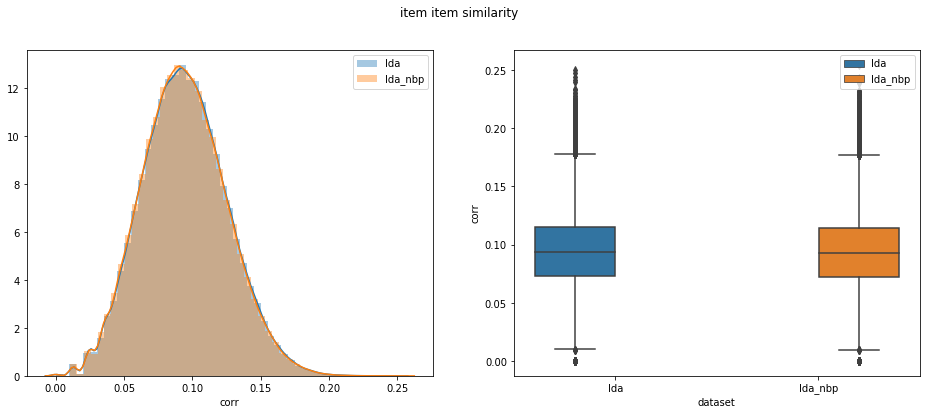

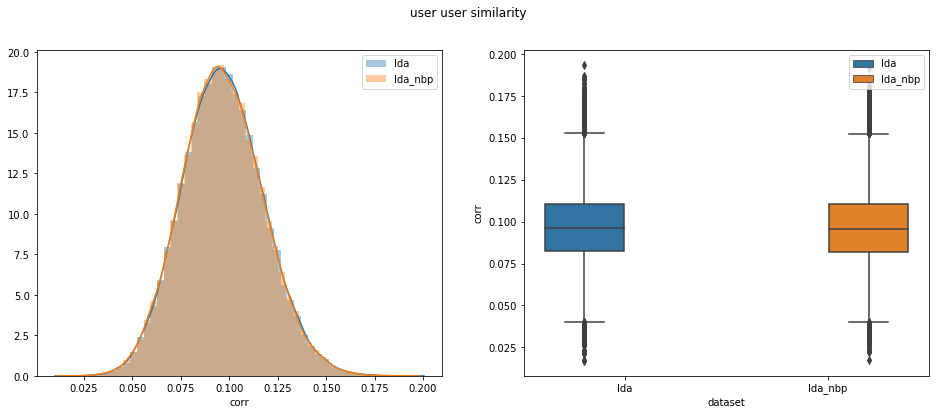

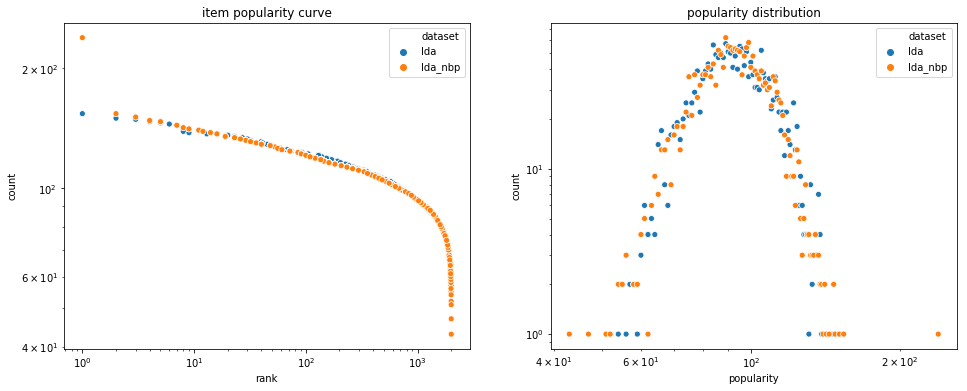

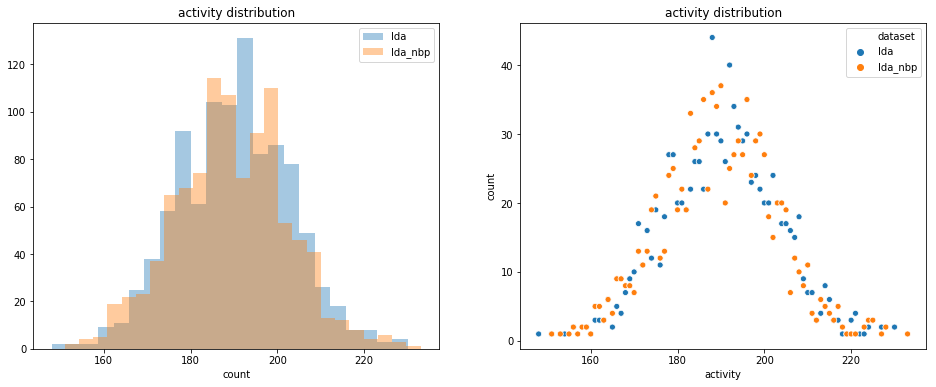

In [29]:
plot_stats(('lda', generate_lda), ('lda_nbp', generate_lda_nbp), [1000, 2000, 100, 200, 0.5, 0.5], [1000, 2000, 100, 200, 0.5, 0.5])

### Calibration
- objective function for `gp_minimize`. 
- pandas vs scipy coo_matrix

In [6]:
ds = DataStats(ml_100k)
nusers = ds.nusers
nitems = ds.nitems
pref = LatentDirichletAllocation(nusers, nitems, 66, 801.8552394276803, 8.578092692834458, 0.01)
trunc_pareto = TruncatedPareto(18.0, 0.1, 548.9611775819028)
obs = PopularityObservation(trunc_pareto)
calibrator = Calibrator(pref, obs, ds, 1)

In [7]:
def objective(**params):
    calibrator.set_params(**params)
    return calibrator.score('ucorr', ntimes=1)

In [8]:
params = {'pref__k': 100, 'pref__lam': 801.8552394276803, 'pref__a': 8.578092692834458, 'pref__b': 0.01,
          'obs__dist_func__m': 18.0, 'obs__dist_func__alpha': 0.1, 'obs__dist_func__upper': 548.9611775819028}

In [9]:
%prun -l 10 objective(**params)

         5439887 function calls (5409159 primitive calls) in 8.391 seconds

   Ordered by: internal time
   List reduced from 1173 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.417    0.417    0.417    0.417 preference.py:533(_draw_lda_user_item)
   740633    0.378    0.000    0.651    0.000 {built-in method builtins.isinstance}
        2    0.284    0.142    0.284    0.142 {built-in method scipy.sparse._sparsetools.csr_matmat_pass2}
        1    0.256    0.256    0.256    0.256 {built-in method scipy.sparse._sparsetools.csr_elmul_csr}
      945    0.230    0.000    0.432    0.000 {method 'choice' of 'mtrand.RandomState' objects}
    18076    0.221    0.000    0.221    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   187951    0.219    0.000    0.407    0.000 shape_base.py:25(atleast_1d)
   392844    0.196    0.000    0.258    0.000 generic.py:7(_check)
        1    0.171    0.171    0.171    0.171 {built-in met

In [10]:
ds = DataStats(ml_100k)
nusers = ds.nusers
nitems = ds.nitems
pref = LatentDirichletAllocationCOO(nusers, nitems, 66, 801.8552394276803, 8.578092692834458, 0.01)
trunc_pareto = TruncParetoProfile(18.0, 0.1, 548.9611775819028)
obs = PopularityObservationCOO(trunc_pareto)
calibrator = CalibratorCOO(pref, obs, ds, 1)

In [11]:
def objective(**params):
    calibrator.set_params(**params)
    return calibrator.score('ucorr', ntimes=1)

In [12]:
params = {'pref__k': 100, 'pref__lam': 801.8552394276803, 'pref__a': 8.578092692834458, 'pref__b': 0.01,
          'obs__dist_func__m': 18.0, 'obs__dist_func__alpha': 0.1, 'obs__dist_func__upper': 548.9611775819028}

In [13]:
%prun -l 10 objective(**params)

         1053316 function calls (1053219 primitive calls) in 2.214 seconds

   Ordered by: internal time
   List reduced from 624 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.434    0.434    0.434    0.434 preference.py:533(_draw_lda_user_item)
        1    0.267    0.267    0.267    0.267 observation.py:359(_sample_popular_foreach)
   189857    0.222    0.000    0.414    0.000 shape_base.py:25(atleast_1d)
        2    0.218    0.109    0.218    0.109 {built-in method scipy.sparse._sparsetools.csr_matmat_pass2}
        1    0.217    0.217    0.217    0.217 {built-in method scipy.sparse._sparsetools.csr_elmul_csr}
        4    0.114    0.029    0.114    0.029 {method 'sort' of 'numpy.ndarray' objects}
        6    0.093    0.015    0.093    0.015 {built-in method numpy.concatenate}
   190111    0.084    0.000    0.084    0.000 {built-in method numpy.array}
        1    0.075    0.075    1.264    1.264 preference.py

### Sampling pairs

In [7]:
nitems = np.unique(np.random.randint(100000000, size=166687))
n = len(nitems)

In [ ]:
def _sample_pairs_n(n, frac, size_cap=int(1e6)):
    sample_size = int(n * (n - 1) / 2 * frac)
    sample_size = min(sample_size, size_cap)
    pairs = np.random.randint(n, size=(sample_size, 2))
    pairs.sort(axis=1)
    pairs = np.unique(pairs, axis=0)
    pairs = pairs[pairs[:, 0] != pairs[:, 1]]
    return pairs

In [ ]:
%timeit _sample_pairs(np.arange(166687), 0.2)
%timeit np.unique(_sample_pairs_nbp(np.arange(166687), 0.2), axis=0)

In [9]:
%timeit _sample_pairs_n(n, 0.2)

1.38 s ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit _sample_pairs(nitems, 0.2)

1.41 s ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%prun -l 10 _sample_pairs_n(n, 0.2)

         38 function calls in 1.440 seconds

   Ordered by: internal time
   List reduced from 26 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    1.332    0.666    1.332    0.666 {method 'sort' of 'numpy.ndarray' objects}
        1    0.062    0.062    0.062    0.062 {method 'randint' of 'mtrand.RandomState' objects}
        1    0.032    0.032    1.440    1.440 calibration.py:193(_sample_pairs_n)
        1    0.012    0.012    1.316    1.316 arraysetops.py:299(_unique1d)
        1    0.002    0.002    0.002    0.002 {method 'flatten' of 'numpy.ndarray' objects}
        1    0.000    0.000    1.440    1.440 <string>:1(<module>)
        1    0.000    0.000    1.440    1.440 {built-in method builtins.exec}
        1    0.000    0.000    1.317    1.317 arraysetops.py:151(unique)
        2    0.000    0.000    0.000    0.000 {method 'view' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 arraysetop

In [13]:
%prun -l 10 _sample_pairs(nitems, 0.2)

         46 function calls in 1.359 seconds

   Ordered by: internal time
   List reduced from 31 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    1.254    0.627    1.254    0.627 {method 'sort' of 'numpy.ndarray' objects}
        1    0.058    0.058    0.058    0.058 {method 'choice' of 'mtrand.RandomState' objects}
        1    0.031    0.031    1.359    1.359 calibration.py:182(_sample_pairs)
        1    0.012    0.012    1.244    1.244 arraysetops.py:299(_unique1d)
        1    0.003    0.003    0.003    0.003 {method 'flatten' of 'numpy.ndarray' objects}
        1    0.000    0.000    1.359    1.359 {built-in method builtins.exec}
        1    0.000    0.000    1.245    1.245 arraysetops.py:151(unique)
        1    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.000    0.000 {method 'view' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000 

### Compute pairs cosine similarity

In [2]:
data = bx_implicit()

In [3]:
data.head()

,user,item,rating
8,8,11834836,5.0
11,8,23296126,6.0
13,8,28160293,7.0
15,8,31937095,5.0
17,8,44862832,5.0


In [4]:
user_idx = pd.Index(data['user'].unique())
item_idx = pd.Index(data['item'].unique())
users = user_idx.get_indexer(data['user']).astype(np.int32, copy=False)
items = item_idx.get_indexer(data['item']).astype(np.int32, copy=False)
ratings = data['rating'].to_numpy(dtype=np.float_)
arr = CSR.from_coo(users,
                   items,
                   ratings)

In [5]:
data_reindex = data.assign(user=users, item=items)

In [6]:
pairs = _sample_pairs_n(len(user_idx), 0.2)

In [8]:
%prun -l 10 compute_cosine_corr(data_reindex, pairs)

         4014 function calls (3969 primitive calls) in 0.753 seconds

   Ordered by: internal time
   List reduced from 381 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.197    0.099    0.197    0.099 {built-in method scipy.sparse._sparsetools.csr_matmat_pass2}
        1    0.184    0.184    0.184    0.184 {method 'sort' of 'numpy.ndarray' objects}
        1    0.132    0.132    0.132    0.132 {built-in method scipy.sparse._sparsetools.csr_elmul_csr}
        2    0.062    0.031    0.062    0.031 {built-in method scipy.sparse._sparsetools.csr_matmat_pass1}
       24    0.027    0.001    0.027    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.022    0.022    0.022    0.022 {built-in method scipy.sparse._sparsetools.csr_sort_indices}
  191/189    0.019    0.000    0.020    0.000 {built-in method numpy.array}
        1    0.015    0.015    0.203    0.203 arraysetops.py:299(_unique1d)
        1    0.015

In [9]:
%prun -l 10 pairwise_cosine(arr.N, pairs)

         1072507 function calls (1004494 primitive calls) in 115.044 seconds

   Ordered by: internal time
   List reduced from 2245 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  113.308  113.308  113.308  113.308 calibration.py:236(pairwise_cosine)
     2735    0.643    0.000    0.645    0.000 ffi.py:106(__call__)
   242319    0.052    0.000    0.064    0.000 {built-in method builtins.isinstance}
31383/6127    0.046    0.000    0.068    0.000 ir.py:197(_rec_list_vars)
28221/12769    0.044    0.000    0.152    0.000 {method 'format' of 'str' objects}
     5096    0.023    0.000    0.070    0.000 instructions.py:14(__init__)
17360/6984    0.022    0.000    0.137    0.000 _utils.py:46(__str__)
     5209    0.019    0.000    0.119    0.000 values.py:220(_to_string)
12659/12637    0.018    0.000    0.035    0.000 _utils.py:56(get_reference)
      474    0.016    0.000    0.022    0.000 controlflow.py:294(_find_dominators_i

In [ ]:
scores1 = compute_cosine_corr(data_reindex, pairs)
scores2 = pairwise_cosine(arr.N, pairs)

### Sample preference size

In [2]:
def sample_preference_size(nusers, nitems, lam):
    user_like_counts = np.zeros(nusers, dtype=np.int64)
    outliers = (user_like_counts > nitems) | (user_like_counts == 0)
    while any(outliers):
        # compute the total number of consumed items for each user as
        # a poisson random variable
        ndraws = np.count_nonzero(outliers)
        user_like_counts[outliers] = np.random.poisson(lam, ndraws)
        outliers = (user_like_counts > nitems) | (user_like_counts == 0)
    return user_like_counts

In [3]:
def sample_preference_sequential(lam, size, cap):
    out = np.empty(size, dtype=np.int64)
    for i in range(size):
        sample = np.random.poisson(lam)
        while (sample > cap) | (sample == 0):
            sample = np.random.poisson(lam)
        out[i] = sample
    return out

In [19]:
%timeit sample_preference_size(100000, 1000000, 2000)
%timeit _draw_poisson_nbp(2000, 100000, 1000000)
%timeit sample_preference_sequential(2000, 100000, 1000000)

16.3 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Truncated_parato
- numpy vs numba

In [4]:
%timeit truncated_pareto(20, 0.5, size=1000000, upper=1000)
%timeit truncated_pareto_nbp(20, 0.5, size=1000000, upper=1000)

38.3 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.78 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
assert all(np.quantile(truncated_pareto(20, 0.5, size=1000000, upper=1000), [0.25, 0.5, 0.75]) == np.quantile(truncated_pareto_nbp(20, 0.5, size=1000000, upper=1000), [0.25, 0.5, 0.75]))

### Sample uniform
- pandas vs numpy

In [2]:
data = ml_100k()

In [11]:
dist_func = TruncatedPareto(20, 0.5, 737)

In [12]:
%timeit sample_uniform_n(data, dist_func)

1min 5s ± 4.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
data.head()

,user,item,rating
8,8,11834836,5.0
11,8,23296126,6.0
13,8,28160293,7.0
15,8,31937095,5.0
17,8,44862832,5.0


In [3]:
coo = coo_matrix((data['rating'].to_numpy(np.float_), (data['user'].to_numpy(np.int32), data['item'].to_numpy(np.int32))))

In [15]:
profile_func = TruncParetoProfile(20, 0.5, 737)

In [17]:
%timeit sample_uniform_coo(coo, profile_func)

26.1 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit sample_uniform_coo_nbp(coo, profile_func)

1.02 s ± 5.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Sample popular
- pandas vs numpy

In [2]:
data = ml_100k()
dist_func = TruncatedPareto(20, 0.5, 737)
coo = coo_matrix((data['rating'].to_numpy(np.float_), (data['user'].to_numpy(np.int32), data['item'].to_numpy(np.int32))))
profile_func = TruncParetoProfile(20, 0.5, 737)

In [3]:
%timeit sample_popular_n(data, dist_func)

3.79 s ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit sample_popular_coo_nbp(coo, profile_func)

94.5 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
pref = LatentDirichletAllocationCOO(943, 1682, 10, 138.67454547771212, 0.15239958231543335, 0.01)
truncated_pareto = TruncParetoProfile(24.424383593824064, 0.1, 404.13652510809106)
obs = UniformObservationCOO(truncated_pareto)
data = ml_100k()
ds = DataStats(data)
calibrator = CalibratorCOO(pref, obs, ds)
score = calibrator.score('ucorr', ntimes=10)
print(score)

0.011220168505012238


In [37]:
pref = LatentDirichletAllocation(943, 1682, 10, 138.67454547771212, 0.15239958231543335, 0.01)
truncated_pareto = TruncatedPareto(24.424383593824064, 0.1, 404.13652510809106)
obs = UniformObservation(truncated_pareto)
data = ml_100k()
ds = DataStats(data)
calibrator = Calibrator(pref, obs, ds)
score = calibrator.score('ucorr', ntimes=10)
print(score)

0.011978985709400324


### Multinomial

In [2]:
k = 100000
a = 0.5
alpha = np.full(k, a)
pvals = np.random.dirichlet(alpha)
n = 1000

In [3]:
%timeit np.random.multinomial(n, pvals)

13 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%timeit multinomial(n, pvals)

8.37 ms ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
pvals = np.random.dirichlet(alpha, n)
nt = np.random.randint(1, 100, size=n)

In [6]:
nt.shape

(1000,)

In [10]:
@njit(parallel=True)
def _draw_multinomial_nbp_tol(n, pvals, tol=1e6):
    nsamples = len(n)
    npvals = pvals.shape[1]
    samples = np.empty((nsamples, npvals), dtype=np.int32)
    # trunc decimals
    p = np.trunc(pvals * tol) / tol
    for i in nb.prange(nsamples):
        samples[i] = np.random.multinomial(n[i], p[i])
    return samples

In [8]:
%timeit _draw_multinomial_nbp(nt, pvals)

427 ms ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit _draw_multinomial_nbp_tol(nt, pvals)

517 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
